In [1]:
import numpy as np
from matplotlib import pyplot as plt

import snntorch as snn
from snntorch import spikegen
import snntorch.functional as SF

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model

import pandas as pd
import json

import cv2

from sklearn.model_selection import train_test_split

In [2]:
!set TF_ENABLE_ONEDNN_OPTS=1

In [3]:
dtype = torch.float

In [4]:
device = "cpu"

In [268]:
ENV = 1
CODE_SIZE = 500
TRAIN_SIZE = 0.20
TEST_NORMAL_SAMPLES = 600
TEST_ANOMALY_SAMPLES = 600
BATCH_SIZE = 32
PRE_TRAIN_EPOCHS = 20
EPOCHS_PER_FRAME = 10
SIGMA = 2
LAMBDA = 0.5 # 0.1

# Data Preprocessing and Loading

In [6]:
def log_sampling_indices_symmetric(size_in, size_out, base=1.2):
    """
    Genera indici di campionamento con densità maggiore al centro e più sparsa ai bordi.
    """
    mid = size_in // 2
    half_log_positions = np.logspace(0, np.log(size_out // 2 + 1) / np.log(base), num=size_out // 2, base=base) - 1
    half_log_positions = (half_log_positions / half_log_positions.max()) * (mid - 1)
    half_log_positions = np.round(half_log_positions).astype(int)
    half_log_positions = np.clip(half_log_positions, 0, mid - 1)
    
    symmetric_indices = np.concatenate((-half_log_positions[::-1], [0], half_log_positions)) + mid
    symmetric_indices = np.clip(symmetric_indices, 0, size_in - 1)  # Per evitare valori fuori limite
    return np.unique(symmetric_indices)  # Evita duplicati

def log_rescale_image(image, size_out=(28, 28), base=1.2):
    """
    Rescala un'immagine secondo una distribuzione logaritmica simmetrica degli indici.
    """
    h_in, w_in = image.shape[:2]
    h_out, w_out = size_out
    
    y_indices = log_sampling_indices_symmetric(h_in, h_out, base)
    x_indices = log_sampling_indices_symmetric(w_in, w_out, base)
    
    rescaled_image = image[np.ix_(y_indices, x_indices)]
    return rescaled_image


In [ ]:
def log_sampling_indices_polar(size_in, size_out, base=1.2, center=None):
    """
    Genera indici di campionamento con densità maggiore al centro e più sparsa ai bordi in coordinate polari.
    """
    if center is None:
        center = (size_in[0] // 2, size_in[1] // 2)
    
    center_y, center_x = center
    max_radius = np.sqrt(center_y**2 + center_x**2)
    
    log_positions = np.logspace(0, np.log(size_out) / np.log(base), num=size_out, base=base) - 1
    log_positions = (log_positions / log_positions.max()) * max_radius
    log_positions = np.round(log_positions).astype(int)
    log_positions = np.clip(log_positions, 0, max_radius - 1)
    
    # print(log_positions)
    angles = np.linspace(0, 2 * np.pi, size_out, endpoint=False)
    
    y_indices = []
    x_indices = []
    
    for r in log_positions:
        for theta in angles:
            y = int(center_y + r * np.sin(theta))
            x = int(center_x + r * np.cos(theta))
            y_indices.append(y)
            x_indices.append(x)
    
    y_indices = np.clip(y_indices, 0, size_in[0] - 1)
    x_indices = np.clip(x_indices, 0, size_in[1] - 1)
    
    return np.unique(y_indices), np.unique(x_indices)

def log_rescale_image_polar(image, size_out=(28, 28), base=1.2, center=None):
    """
    Rescala un'immagine secondo una distribuzione logaritmica in coordinate polari.
    """
    h_in, w_in = image.shape[:2]
    h_out, w_out = size_out
    
    if center is None:
        center = (h_in // 2, w_in // 2)
    
    y_indices, x_indices = log_sampling_indices_polar((h_in, w_in), max(h_out, w_out), base, center)
    
    mask = np.zeros((h_in,w_in))
    mask[np.ix_(y_indices, x_indices)] = 1

    rescaled_image = image[np.ix_(y_indices, x_indices)]
    return rescaled_image

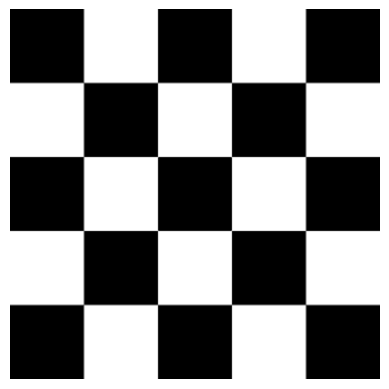

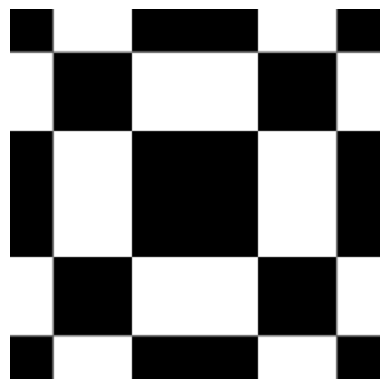

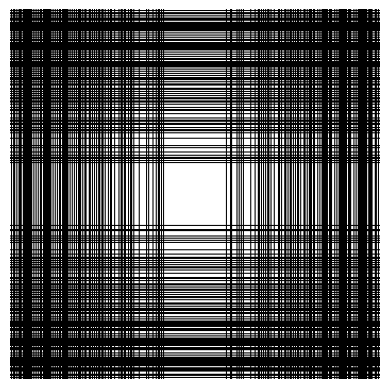

In [11]:


path = "Scacchi.png"
img = cv2.imread(path,0)

rescaled_image, aa= log_rescale_image_polar(img, size_out=(28, 28), base=1.2)

plt.imshow(img,cmap='gray') 
plt.axis('off')
plt.show()
plt.imshow(rescaled_image, cmap='gray')
# print(rescaled_image.shape)
plt.axis('off')
plt.show()

plt.imshow(aa,cmap='gray') 
plt.axis('off')
plt.show()


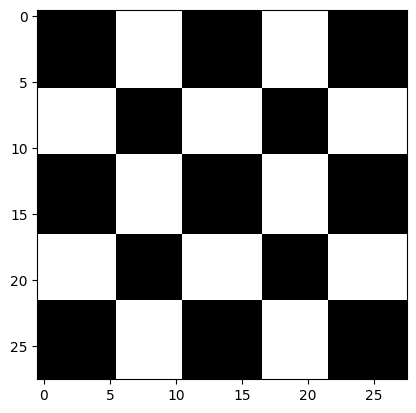

In [13]:
res = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
plt.imshow(res, cmap='gray')

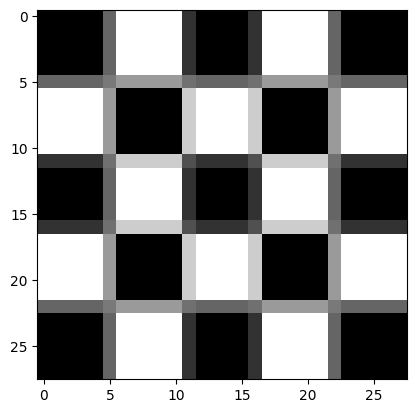

In [14]:
res = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_AREA)
plt.imshow(res, cmap='gray')

In [15]:
def log_resize(img,alpha=0.05,beta=5):
        
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2  # Centro
    d = np.sqrt(cx**2 + cy**2)  # Distanza massima

    # Parametri per modulare l'effetto
    # alpha = 1 # Prova ad aumentarlo se la maschera è troppo piatta
    beta = 5 # Abbassa per rendere meno espansa la zona centrale

    # Creazione della maschera lineare, puoi anche sperimentare con altre funzioni
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
    distance = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)

    # Modifica della formula per la maschera
    mask = (distance / d)  # Usa una relazione lineare per la distanza
    mask = 1 - alpha * mask  # Inverti per dare più peso al centro
    mask = np.clip(mask, 0, 1)  # Mantieni valori tra 0 e 1

    # Debug: Controlla i valori della maschera
    #print(f"Valori maschera (min, max): {mask.min()}, {mask.max()}")

    # Applica la maschera direttamente all'immagine in scala di grigi
    img_weighted = img * mask

    # Debug: Controlla i valori dell'immagine pesata
    #print(f"Valori immagine pesata (min, max): {img_weighted.min()}, {img_weighted.max()}")

    # Converti a uint8
    img_weighted = np.clip(img_weighted, 0, 255).astype(np.uint8)

    # Ridimensiona a 28x28
    img_resized = cv2.resize(img_weighted, (28, 28), interpolation=cv2.INTER_AREA)

    return img_resized,mask

In [16]:
with open("metadata/envs_mapping.txt","r") as f:
    envs_mapping= json.loads(f.read())
envs_mapping

{'underground': 0, '1long': 1, '1short': 2}

In [17]:
with open("metadata/labels_mapping.txt","r") as f:
    labels_mapping= json.loads(f.read())
labels_mapping

{'normal': 0,
 'box': 1,
 'cable': 2,
 'cones': 3,
 'debris': 4,
 'defects': 5,
 'door': 6,
 'floor': 7,
 'human': 8,
 'misc': 9,
 'tape': 10,
 'trolley': 11,
 'clutter': 12,
 'foam': 13,
 'sawdust': 14,
 'shard': 15,
 'cellophane': 16,
 'screws': 17,
 'water': 18,
 'obj. on robot': 19,
 'obj. on robot2': 20}

In [18]:
env_df = pd.read_csv("metadata/training_mixed_set_frames_envs.csv")
env_df.head()

,frame_id,env
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [19]:
label_df = pd.read_csv("metadata/training_mixed_frames_labels.csv")
label_df.head()

,frame_id,label
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [20]:
len(env_df)

144603

In [21]:
len(label_df)

144603

In [22]:
data_df = pd.merge(env_df,label_df,how="left")

In [23]:
data_df.head()

,frame_id,env,label
0,0,1,1
1,1,1,1
2,2,1,1
3,3,1,1
4,4,1,1


In [24]:
normal_df = data_df[(data_df["env"] == ENV) & (data_df["label"] == 0)].reset_index(drop=True)

In [25]:
normal_df["frame_id"] =  normal_df["frame_id"].astype(str).str.zfill(6)

In [26]:
normal_df.head()

,frame_id,env,label
0,094362,1,0
1,094363,1,0
2,094364,1,0
3,094365,1,0
4,094366,1,0


In [27]:
len(normal_df)

15655

In [28]:
anomaly_df = data_df[(data_df["env"] == ENV) & ((data_df["label"] == 8))].reset_index(drop=True)

In [29]:
anomaly_df["frame_id"] =  anomaly_df["frame_id"].astype(str).str.zfill(6)

In [30]:
anomaly_df.head()

,frame_id,env,label
0,009753,1,8
1,009754,1,8
2,009755,1,8
3,009756,1,8
4,009757,1,8


In [31]:
len(anomaly_df)

5946

In [32]:
train_df, rem_df = train_test_split(normal_df,train_size=TRAIN_SIZE,shuffle=False)

In [33]:
len(train_df)

3131

In [34]:
len(rem_df)

12524

In [35]:
train_df.reset_index(drop=True,inplace=True)

In [36]:
train_df.head()

,frame_id,env,label
0,094362,1,0
1,094363,1,0
2,094364,1,0
3,094365,1,0
4,094366,1,0


In [37]:
test_df = pd.concat([rem_df.iloc[0:TEST_NORMAL_SAMPLES],anomaly_df.iloc[0:TEST_ANOMALY_SAMPLES]]).reset_index(drop=True)

In [38]:
test_df.head()

,frame_id,env,label
0,097493,1,0
1,097494,1,0
2,097495,1,0
3,097496,1,0
4,097497,1,0


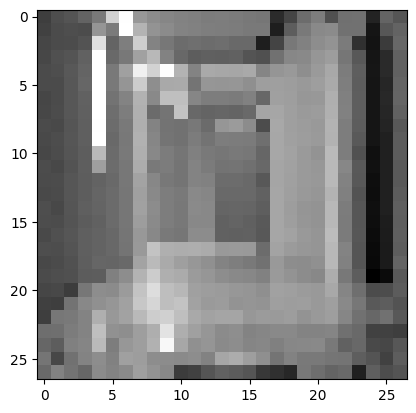

In [39]:

path = "training_mixed_set/unlabeled_set/"+test_df.iloc[799]["frame_id"]+"_512_512.jpg"
img = cv2.imread(path,0)

rescaled_image = log_rescale_image(img, size_out=(28, 28), base=1.2)

plt.imshow(rescaled_image,cmap='gray')

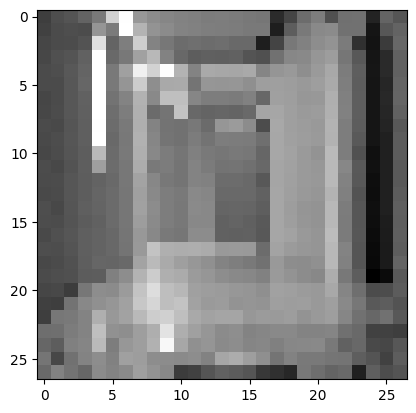

(512, 512)
(27, 27)


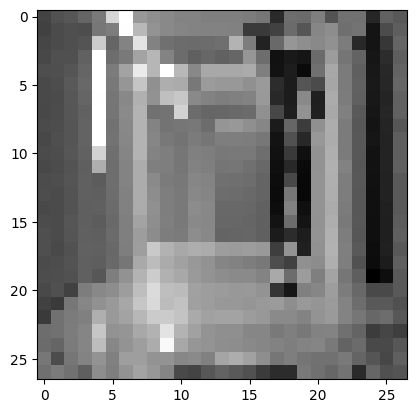

In [40]:


path = "training_mixed_set/unlabeled_set/"+test_df.iloc[799]["frame_id"]+"_512_512.jpg"
img = cv2.imread(path,0)


rescaled_image = log_rescale_image(img, size_out=(28, 28), base=1.2)

# plt.imshow(img,cmap='gray') 
# plt.axis('off')
# plt.show()
plt.imshow(rescaled_image, cmap='gray')
# print(rescaled_image.shape)
# plt.axis('off')
plt.show()




path = "training_mixed_set/unlabeled_set/"+test_df.iloc[990]["frame_id"]+"_512_512.jpg"
img = cv2.imread(path,0)
print(img.shape)

rescaled_image = log_rescale_image(img, size_out=(28, 28), base=1.2)

# plt.imshow(img,cmap='gray') 
# plt.axis('off')
# plt.show()
plt.imshow(rescaled_image, cmap='gray')
print(rescaled_image.shape)
# plt.axis('off')
plt.show()


In [41]:
X_train = []
for i in range(len(train_df)):
    path = "training_mixed_set/unlabeled_set/"+train_df.iloc[i]["frame_id"]+"_512_512.jpg"
    img = cv2.imread(path,0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (28, 28))
    img = log_rescale_image(img)
    X_train.append(img)
X_train = (np.array(X_train)/255.0).astype(float)

In [42]:
X_train[0].shape

(27, 27)

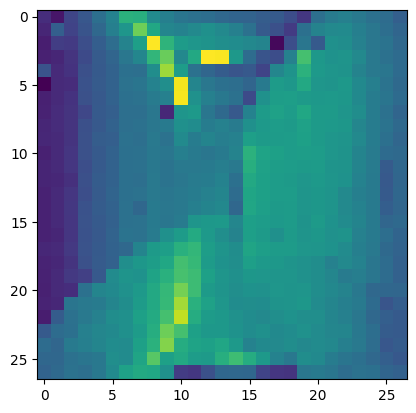

In [43]:
plt.imshow(X_train[0])

In [44]:
X_test = []
for i in range(len(test_df)):
    path = "training_mixed_set/unlabeled_set/"+test_df.iloc[i]["frame_id"]+"_512_512.jpg"
    img = cv2.imread(path,0)
    img = cv2.resize(img, (224, 224))
    X_test.append(img)
X_test = (np.array(X_test)/255.0).astype(float)

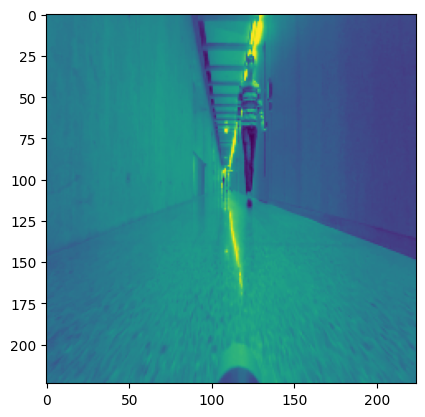

In [45]:
plt.imshow(X_test[-1])

In [46]:
X_test_lr = []
for i in range(len(test_df)):
    path = "training_mixed_set/unlabeled_set/"+test_df.iloc[i]["frame_id"]+"_512_512.jpg"
    img = cv2.imread(path,0)
    img = log_rescale_image(img)
    X_test_lr.append(img)
X_test_lr = (np.array(X_test_lr)/255.0).astype(float)

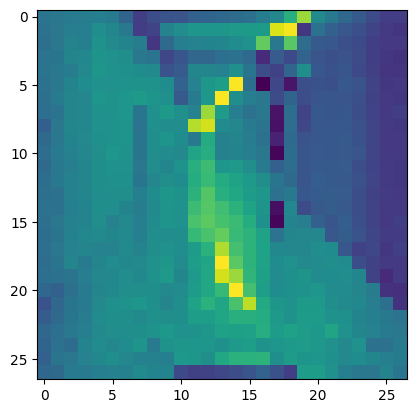

In [47]:
plt.imshow(X_test_lr[-1])

In [48]:
X_train = np.reshape(X_train,(-1,729))
X_train.shape

(3131, 729)

In [49]:
y_train = np.array(train_df["label"])
y_train.shape

(3131,)

In [50]:
X_test = np.reshape(X_test,(-1,224,224,1))
X_test.shape

(1200, 224, 224, 1)

In [51]:
X_test_lr = np.reshape(X_test_lr,(-1,729))
X_test_lr.shape

(1200, 729)

In [52]:
y_test = np.array(test_df["label"])
y_test = (y_test != 0).astype(int)
y_test.shape

(1200,)

In [53]:
sum(y_test == 0)

np.int64(600)

In [54]:
sum(y_test == 1)

np.int64(600)

# Utility Functions

In [198]:
def train(model,train_dataloader,val_dataloader,epochs,loss_fn,optimizer):
    
    train_losses = []
    val_losses = []

    for e in range(epochs):
        train_batch = iter(train_dataloader)
    
        train_loss_epoch = 0
        val_loss_epoch = 0
    
        for data, targets in tqdm(train_batch):
            data = data.to(device)
            targets = targets.to(device)
        
            model.train()
            # spk_rec, mem_rec, 
            x_recon = model(data.view(len(data), -1))

            # loss_val = torch.zeros((1), dtype=dtype, device=device)

            loss_val = loss_fn(x_recon, targets)
            # for step in range(model.num_steps):
            #     loss_val += loss_fn(mem_rec[step], targets)
                #spk_rec
         
            train_loss_epoch += loss_val.item()

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # with torch.no_grad():
            #     model.eval()
            #     val_data, val_targets = next(iter(val_dataloader))
            #     val_data = val_data.to(device)
            #     val_targets = val_targets.to(device)

            #     # val_spk, val_mem,
            #     x_recon = model(val_data.view(len(val_data), -1))

            #     val_loss = loss_fn(x_recon, targets)
            #     # val_loss = torch.zeros((1), dtype=dtype, device=device)
            #     # for step in range(model.num_steps):
            #     #     val_loss += loss_fn(val_mem[step], val_targets*model)
            #         #val_spk
                
            #     #recon = torch.mean(val_mem,axis=0)
            #     #val_loss = loss_fn(recon,val_targets)
        
            # val_loss_epoch += val_loss.item()
        
        print(f"Train loss at epoch: {e+1}: {train_loss_epoch}")
        print(f"Val loss at epoch: {e+1}: {val_loss_epoch}")
    
        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
    
    return train_losses,val_losses

In [199]:
class IncrementalLoss(nn.Module):
    def __init__(self, lambda_=0.1):
        super(IncrementalLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_ = lambda_
        self.previous_weights = None 

    def set_previous_weights(self, model):
        self.previous_weights = {name: param.clone().detach() for name, param in model.named_parameters()}

    def forward(self, predictions, targets, model):
        loss_mse = self.mse(predictions, targets)

        if self.previous_weights is None:
            return loss_mse

        weight_penalty = 0.0
        param_count = 0
        for name, param in model.named_parameters():
            if name in self.previous_weights:
                diff = param - self.previous_weights[name]
                weight_penalty += torch.sum(diff ** 2)
                param_count += diff.numel()
        
    
        scale_factor = loss_mse.item() / (weight_penalty.item() + 1e-8)  
        total_loss = loss_mse + self.lambda_ * scale_factor * weight_penalty
        
        #print("MSE: ", loss_mse)
        #print("Weight penalty: ", self.lambda_ * scale_factor * weight_penalty)
    
        return total_loss

In [200]:
def magic_train(model,train_dataloader,val_dataloader,epochs,loss_fn,optimizer):
    
    train_losses = []

    for e in range(epochs):
        train_batch = iter(train_dataloader)
    
        train_loss_epoch = 0
        val_loss_epoch = 0
    
        for data, targets in tqdm(train_batch):
            data = data.to(device)
            targets = targets.to(device)
        
            model.train()
            x_recon = model(data.view(len(data), -1))

            # loss_val = torch.zeros((1), dtype=dtype, device=device)
            # for step in range(model.num_steps):
            #     loss_val += loss_fn(spk_rec[step], targets, model)
            
            loss_val = loss_fn(x_recon, targets)
            #recon = torch.mean(mem_rec,axis=0)
            #loss_val = loss_fn(recon,targets,model)
            
            train_loss_epoch += loss_val.item()

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
        
        print(f"Train loss at epoch: {e+1}: {train_loss_epoch}")
    
        train_losses.append(train_loss_epoch)
    
    return train_losses

In [201]:
def compute_reconstruction_error(model,sample):
    model.eval()
    recon = model(sample)
    # mem = torch.mean(mem,axis=0)
    mse = torch.nn.MSELoss()
    return mse(sample,recon).item()

In [202]:
def compute_reconstructions(model,sample):
    model.eval()
    recon = model(sample)
    # mem = torch.mean(mem,axis=0)
    error = torch.square(sample - recon)
    error = torch.mean(error,axis=1)
    return error

In [203]:
# Cose da attenzionare:

# 1) Normalizzazione del lambda ===> Fatto
# 2) Pre-allenamento su un gruppo normale (senza usare incremental) ====> Fatto
# 3) Possibilità di rendere dinamico l'hidden layer (Future works)
# 4) Valutazione FP, FN al variare threshold ==> Fatto

# Magic Loop Pazzo Sgravato

In [204]:
# class SAE(nn.Module):
#     def __init__(self,num_inputs,num_hidden,num_steps=25,beta=0.95):
#         super().__init__()
        
#         self.num_inputs = num_inputs
#         self.num_hidden = num_hidden
#         self.num_steps = num_steps
#         self.beta = beta
        
#         self.fc1 = nn.Linear(self.num_inputs,self.num_hidden)
#         self.lif1 = snn.Leaky(beta=self.beta)
#         self.fc2 = nn.Linear(self.num_hidden, self.num_inputs)
#         self.lif2 = snn.Leaky(beta=self.beta, threshold=20000, output=True)

#     def forward(self, x):

#         mem1 = self.lif1.init_leaky()
#         mem2 = self.lif2.init_leaky()
        
#         spk2_rec = []
#         mem2_rec = []
        
#         for step in range(self.num_steps):
#             # x = spikegen.rate(x, num_steps=1)
#             # x = np.squeeze(x,0)
#             # break
#             cur1 = self.fc1(x)
#             spk1, mem1 = self.lif1(cur1, mem1)
#             cur2 = self.fc2(spk1)
#             spk2, mem2 = self.lif2(cur2, mem2)
#             # print(mem2.detach().numpy()[:,0])
#             spk2_rec.append(spk2)
#             mem2_rec.append(mem2)
#             # out = (mem2_rec[0][-1])
            
#             # print(mem2_rec[0].detach().numpy()[:,:,0])

#         return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
#     # , out

In [205]:
import torch
import torch.nn as nn
import snntorch as snn

class SAE(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_steps=25, beta=0.95):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_steps = num_steps
        self.beta = beta
        
        # Definizione dei layer
        self.fc1 = nn.Linear(self.num_inputs, self.num_hidden)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(self.num_hidden, self.num_inputs)
        self.lif2 = snn.Leaky(beta=self.beta, threshold=20000, output=True)
    
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk_mem1, spk_mem2 = [], []
        
        for step in range(self.num_steps):
            mem1 = self.fc1(x)
            spk1, mem1 = self.lif1(mem1)
            mem2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(mem2)
            
            spk_mem1.append(spk1)
            spk_mem2.append(mem2)
        
        spk_mem1 = torch.stack(spk_mem1, dim=2)
        spk_mem2 = torch.stack(spk_mem2, dim=2)
        
        return spk_mem2[:, :, -1]  # Restituisce il potenziale di membrana all'ultimo passo temporale

In [206]:
magic_cnn = load_model("AD_Loop_base.keras")

In [207]:
magic_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,294,853 (4.94 MB)

 Trainable params: 431,617 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 863,236 (3.29 MB)

# Magic-SAE Pre-training

In [208]:
X_train = X_train[0:int(0.80*len(X_train))]
X_val = X_train[int(0.80*len(X_train)):]
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)

In [238]:
pre_train_dataset = TensorDataset(X_train,X_train)
pre_train_dataloader = DataLoader(pre_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val,X_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

loss_fn = torch.nn.MSELoss()
magic_sae = SAE(729,CODE_SIZE,num_steps=30)
optimizer = torch.optim.Adam(magic_sae.parameters(), lr=1e-3, betas=(0.9, 0.999))

# for e in range(20):
#     train_loss = train(magic_sae, pre_train_dataloader, optimizer, e)
train_losses, val_losses = train(magic_sae,pre_train_dataloader,val_dataloader,PRE_TRAIN_EPOCHS,loss_fn,optimizer)

100%|██████████| 63/63 [00:03<00:00, 18.82it/s]


Train loss at epoch: 1: 11.013106397353113
Val loss at epoch: 1: 0


100%|██████████| 63/63 [00:03<00:00, 18.83it/s]


Train loss at epoch: 2: 0.8242021473124623
Val loss at epoch: 2: 0


100%|██████████| 63/63 [00:03<00:00, 18.91it/s]


Train loss at epoch: 3: 0.6957130813971162
Val loss at epoch: 3: 0


100%|██████████| 63/63 [00:03<00:00, 17.75it/s]


Train loss at epoch: 4: 0.5970730180852115
Val loss at epoch: 4: 0


100%|██████████| 63/63 [00:03<00:00, 17.62it/s]


Train loss at epoch: 5: 0.5516629731282592
Val loss at epoch: 5: 0


100%|██████████| 63/63 [00:03<00:00, 16.56it/s]


Train loss at epoch: 6: 0.4950378071516752
Val loss at epoch: 6: 0


100%|██████████| 63/63 [00:03<00:00, 17.20it/s]


Train loss at epoch: 7: 0.46767282439395785
Val loss at epoch: 7: 0


100%|██████████| 63/63 [00:03<00:00, 17.63it/s]


Train loss at epoch: 8: 0.4364486541599035
Val loss at epoch: 8: 0


100%|██████████| 63/63 [00:03<00:00, 18.19it/s]


Train loss at epoch: 9: 0.4112520623020828
Val loss at epoch: 9: 0


100%|██████████| 63/63 [00:03<00:00, 18.62it/s]


Train loss at epoch: 10: 0.37344971438869834
Val loss at epoch: 10: 0


100%|██████████| 63/63 [00:03<00:00, 18.72it/s]


Train loss at epoch: 11: 0.3558804467320442
Val loss at epoch: 11: 0


100%|██████████| 63/63 [00:03<00:00, 18.44it/s]


Train loss at epoch: 12: 0.3428089921362698
Val loss at epoch: 12: 0


100%|██████████| 63/63 [00:03<00:00, 17.23it/s]


Train loss at epoch: 13: 0.34226345736533403
Val loss at epoch: 13: 0


100%|██████████| 63/63 [00:03<00:00, 17.54it/s]


Train loss at epoch: 14: 0.32527712266892195
Val loss at epoch: 14: 0


100%|██████████| 63/63 [00:03<00:00, 17.48it/s]


Train loss at epoch: 15: 0.3104692786000669
Val loss at epoch: 15: 0


100%|██████████| 63/63 [00:03<00:00, 17.95it/s]


Train loss at epoch: 16: 0.3007141116540879
Val loss at epoch: 16: 0


100%|██████████| 63/63 [00:03<00:00, 18.32it/s]


Train loss at epoch: 17: 0.29086070926859975
Val loss at epoch: 17: 0


100%|██████████| 63/63 [00:03<00:00, 18.67it/s]


Train loss at epoch: 18: 0.2784177931025624
Val loss at epoch: 18: 0


100%|██████████| 63/63 [00:03<00:00, 18.93it/s]


Train loss at epoch: 19: 0.27204528194852173
Val loss at epoch: 19: 0


100%|██████████| 63/63 [00:03<00:00, 18.92it/s]

Train loss at epoch: 20: 0.2680216687731445
Val loss at epoch: 20: 0


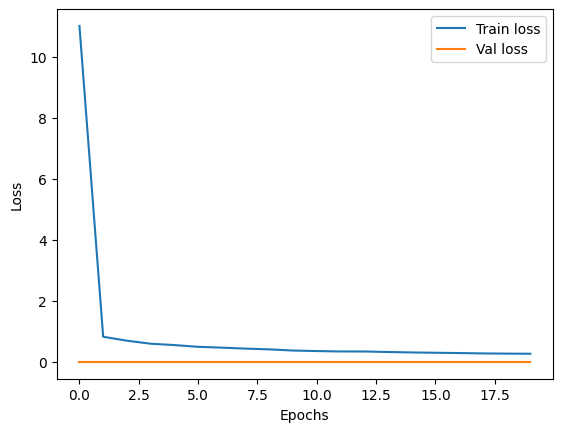

In [239]:
plt.plot(train_losses,label="Train loss")
plt.plot(val_losses,label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")

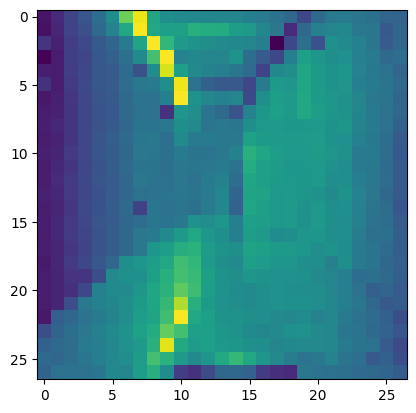

In [240]:
TRAIN_ID = 10
plt.imshow(X_train[TRAIN_ID].reshape(27,27))

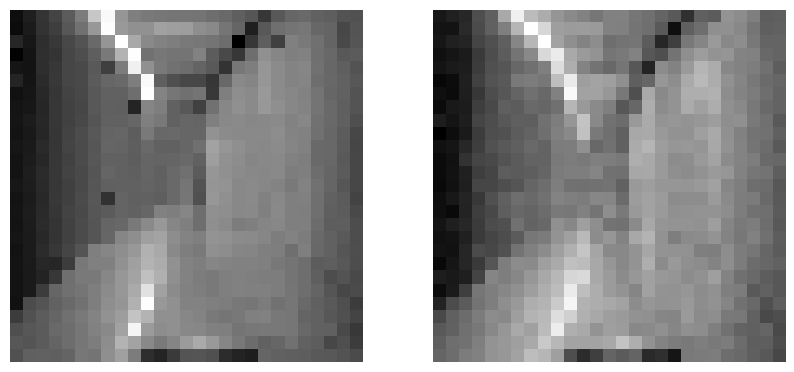

In [241]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(X_train[TRAIN_ID].reshape(27,27), cmap='gray')
axes[0].axis('off')
# axes[0].set_title('Original Image')
magic_sae.eval()
a = magic_sae(torch.Tensor(X_train[TRAIN_ID]).reshape(1,-1))
# Display the second image
axes[1].imshow(a.detach().numpy().reshape(27,27), cmap='gray')
axes[1].axis('off')
# axes[1].set_title('Rescaled Image')

plt.show()

In [242]:
compute_reconstruction_error(magic_sae,X_val) 
compute_reconstruction_error(magic_sae,X_train) 

0.00418589124456048

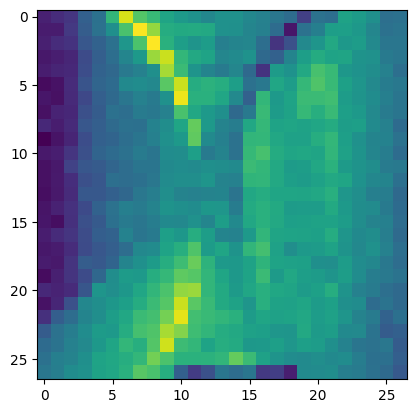

In [243]:
magic_sae.eval()
a = magic_sae(torch.Tensor(X_train[TRAIN_ID]).reshape(1,-1))
# c = torch.mean(b,axis=0)
plt.imshow(a.detach().numpy().reshape(27,27))

# Threshold definition

In [244]:
THR = compute_reconstruction_error(magic_sae,X_train) * SIGMA
THR

0.00837178248912096

In [245]:
e = compute_reconstructions(magic_sae,X_train)
print(torch.mean(e))
print(torch.mean(e)*SIGMA)
print(torch.var(e))

tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MulBackward0>)
tensor(5.7632e-06, grad_fn=<VarBackward0>)


# Training with Pre-Trained SAE

In [264]:
frame_errors = []
preds = []
FP = []
FN = [] 

for frame in range(len(X_test)):
    
    # Low res
    sample = X_test_lr[frame]
    #sample = cv2.resize(sample, (28, 28))
    #sample = log_resize(sample)
    sample = torch.Tensor(sample)
    sample = torch.reshape(sample,(-1,729))
    frame_err = compute_reconstruction_error(magic_sae,sample)
    frame_errors.append(frame_err)

    # Anomaly detected
    if frame_err > THR:
        preds.append(1)
        if y_test[frame] == 0:
            FP.append(frame)
    else:
        preds.append(0)
        if y_test[frame] == 1:
            FN.append(frame)   

(0.0, 0.2)

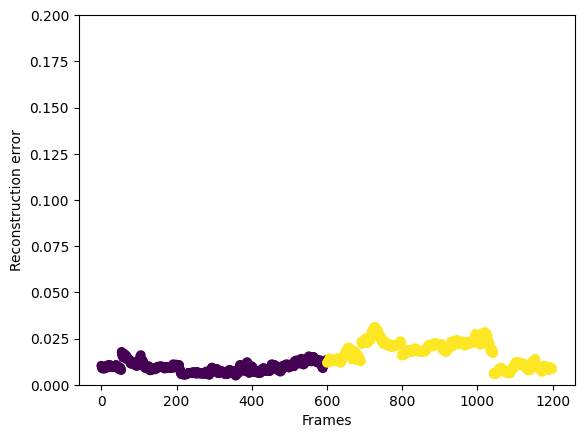

In [247]:
#plt.plot(frame_errors)
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=y_test)
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))


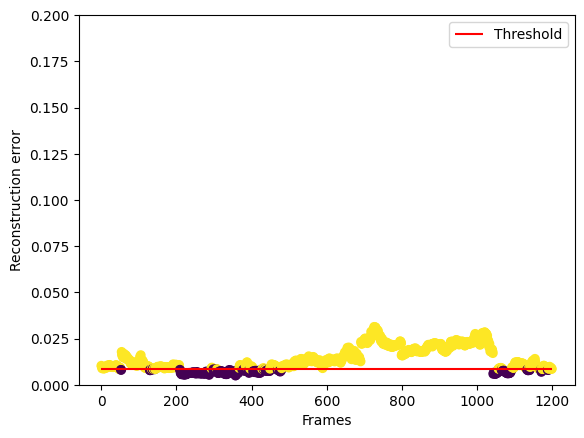

In [248]:
#plt.plot(frame_errors)
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=preds)
plt.hlines(y=THR,xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")

In [249]:
print("False Positives: ", len(FP))
print("False Negatives: ", len(FN))

False Positives:  380
False Negatives:  54


In [219]:
loss_fn = IncrementalLoss(lambda_=LAMBDA)
loss_fn =  torch.nn.MSELoss()
optimizer = torch.optim.Adam(magic_sae.parameters(), lr=1e-3, betas=(0.9, 0.999)) # Prova

# Magic Training

In [250]:
frame_errors = []
preds = []
FP = []
FN = [] 

for frame in range(len(X_test)):
    
    # Low res
    sample = X_test_lr[frame]
    #sample = cv2.resize(sample, (28, 28))
    #sample = log_resize(sample)
    sample = torch.Tensor(sample)
    sample = torch.reshape(sample,(-1,729))
    frame_err = compute_reconstruction_error(magic_sae,sample)
    frame_errors.append(frame_err)

    # Anomaly detected
    if frame_err > THR:
        
        preds.append(1)
        
        # TO-DO:
        # p = magic_cnn()
        #...
  
        if y_test[frame] == 0:
            FP.append(frame)
            # Normal: We adapt the magic SAE
            print(f"Training on frame: {frame+1}")
            train_dataset = TensorDataset(sample,sample)
            train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False) 
            magic_train(magic_sae,train_dataloader,train_dataloader,EPOCHS_PER_FRAME,loss_fn,optimizer)
            # loss_fn.set_previous_weights(magic_sae)
        else:
            # Anomaly: Nothing to do here, we recognized the anomaly
            pass
    else:
        
        preds.append(0)
        if y_test[frame] == 1:
            FN.append(frame)

Training on frame: 1


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 0.010296872816979885


100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


Train loss at epoch: 2: 0.01577882096171379


100%|██████████| 1/1 [00:00<00:00, 29.67it/s]


Train loss at epoch: 3: 0.00564451701939106


100%|██████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 4: 0.008120520040392876


100%|██████████| 1/1 [00:00<00:00, 28.82it/s]


Train loss at epoch: 5: 0.013543504290282726


100%|██████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 6: 0.005488963332027197


100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 7: 0.01632617972791195


100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 8: 0.011166204698383808


100%|██████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 9: 0.012010850012302399


100%|██████████| 1/1 [00:00<00:00, 29.08it/s]


Train loss at epoch: 10: 0.018523065373301506
Training on frame: 28


100%|██████████| 1/1 [00:00<00:00, 26.05it/s]


Train loss at epoch: 1: 0.009100078605115414


100%|██████████| 1/1 [00:00<00:00, 34.88it/s]


Train loss at epoch: 2: 0.009015788324177265


100%|██████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 3: 0.00672181649133563


100%|██████████| 1/1 [00:00<00:00, 29.98it/s]


Train loss at epoch: 4: 0.00433692941442132


100%|██████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 5: 0.006142669357359409


100%|██████████| 1/1 [00:00<00:00, 30.02it/s]


Train loss at epoch: 6: 0.004268995951861143


100%|██████████| 1/1 [00:00<00:00, 29.98it/s]


Train loss at epoch: 7: 0.004722109064459801


100%|██████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 8: 0.004952084273099899


100%|██████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 9: 0.006478256545960903


100%|██████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 10: 0.005397810600697994
Training on frame: 43


100%|██████████| 1/1 [00:00<00:00, 27.27it/s]


Train loss at epoch: 1: 0.009182890877127647


100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 2: 0.004859305452555418


100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 3: 0.004831353202462196


100%|██████████| 1/1 [00:00<00:00, 44.37it/s]


Train loss at epoch: 4: 0.0037064312491565943


100%|██████████| 1/1 [00:00<00:00, 29.79it/s]


Train loss at epoch: 5: 0.002257789019495249


100%|██████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 6: 0.0020974052604287863


100%|██████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 7: 0.002943778643384576


100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 8: 0.002689920598641038


100%|██████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 9: 0.004118968266993761


100%|██████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 10: 0.003755419747903943
Training on frame: 55


100%|██████████| 1/1 [00:00<00:00, 30.64it/s]


Train loss at epoch: 1: 0.03413929045200348


100%|██████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 2: 0.024705013260245323


100%|██████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 3: 0.0201956108212471


100%|██████████| 1/1 [00:00<00:00, 29.55it/s]


Train loss at epoch: 4: 0.008530099876224995


100%|██████████| 1/1 [00:00<00:00, 28.70it/s]


Train loss at epoch: 5: 0.0064339651726186275


100%|██████████| 1/1 [00:00<00:00, 22.67it/s]


Train loss at epoch: 6: 0.005346211604773998


100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


Train loss at epoch: 7: 0.0024850312620401382


100%|██████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 8: 0.005998700391501188


100%|██████████| 1/1 [00:00<00:00, 28.38it/s]


Train loss at epoch: 9: 0.005910472013056278


100%|██████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 10: 0.005716278683394194
Training on frame: 57


100%|██████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 0.013987790793180466


100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


Train loss at epoch: 2: 0.011406635865569115


100%|██████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 3: 0.010466880165040493


100%|██████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 4: 0.0077110035344958305


100%|██████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 5: 0.0046720257960259914


100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


Train loss at epoch: 6: 0.003897447371855378


100%|██████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 7: 0.0023803100921213627


100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Train loss at epoch: 8: 0.001524323015473783


100%|██████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 9: 0.0032838901970535517


100%|██████████| 1/1 [00:00<00:00, 29.31it/s]


Train loss at epoch: 10: 0.0016194500494748354
Training on frame: 59


100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


Train loss at epoch: 1: 0.010645709000527859


100%|██████████| 1/1 [00:00<00:00, 20.34it/s]


Train loss at epoch: 2: 0.009787458926439285


100%|██████████| 1/1 [00:00<00:00, 27.00it/s]


Train loss at epoch: 3: 0.010279933921992779


100%|██████████| 1/1 [00:00<00:00, 21.66it/s]


Train loss at epoch: 4: 0.006119776051491499


100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Train loss at epoch: 5: 0.0051600015722215176


100%|██████████| 1/1 [00:00<00:00, 30.11it/s]


Train loss at epoch: 6: 0.003944769036024809


100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Train loss at epoch: 7: 0.002466463018208742


100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


Train loss at epoch: 8: 0.002286040922626853


100%|██████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 9: 0.0018195753218606114


100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Train loss at epoch: 10: 0.001354226958937943
Training on frame: 61


100%|██████████| 1/1 [00:00<00:00, 29.61it/s]


Train loss at epoch: 1: 0.009334982372820377


100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 2: 0.009004922583699226


100%|██████████| 1/1 [00:00<00:00, 20.39it/s]


Train loss at epoch: 3: 0.008170816116034985


100%|██████████| 1/1 [00:00<00:00, 20.78it/s]


Train loss at epoch: 4: 0.007491161581128836


100%|██████████| 1/1 [00:00<00:00, 27.24it/s]


Train loss at epoch: 5: 0.006937676575034857


100%|██████████| 1/1 [00:00<00:00, 21.97it/s]


Train loss at epoch: 6: 0.005882303696125746


100%|██████████| 1/1 [00:00<00:00, 29.21it/s]


Train loss at epoch: 7: 0.006553628481924534


100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


Train loss at epoch: 8: 0.004338120110332966


100%|██████████| 1/1 [00:00<00:00, 28.06it/s]


Train loss at epoch: 9: 0.0041826325468719006


100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


Train loss at epoch: 10: 0.002967722713947296
Training on frame: 64


100%|██████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 0.011943131685256958


100%|██████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 2: 0.011721992865204811


100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Train loss at epoch: 3: 0.009828755632042885


100%|██████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 4: 0.009402772411704063


100%|██████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 5: 0.007490925956517458


100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 6: 0.005563795566558838


100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Train loss at epoch: 7: 0.004077676683664322


100%|██████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 8: 0.003973550628870726


100%|██████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 9: 0.002937036333605647


100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Train loss at epoch: 10: 0.002154924673959613
Training on frame: 68


100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 0.008458864875137806


100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 2: 0.007668412756174803


100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


Train loss at epoch: 3: 0.008738907985389233


100%|██████████| 1/1 [00:00<00:00, 36.91it/s]


Train loss at epoch: 4: 0.0068948520347476006


100%|██████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 5: 0.00844850018620491


100%|██████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 6: 0.00534394197165966


100%|██████████| 1/1 [00:00<00:00, 29.27it/s]


Train loss at epoch: 7: 0.005548955872654915


100%|██████████| 1/1 [00:00<00:00, 20.15it/s]


Train loss at epoch: 8: 0.004585085436701775


100%|██████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 9: 0.003916491754353046


100%|██████████| 1/1 [00:00<00:00, 20.45it/s]


Train loss at epoch: 10: 0.003821573220193386
Training on frame: 71


100%|██████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 0.008770025335252285


100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Train loss at epoch: 2: 0.009736819192767143


100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Train loss at epoch: 3: 0.009594175964593887


100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


Train loss at epoch: 4: 0.005943359341472387


100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


Train loss at epoch: 5: 0.008118254132568836


100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


Train loss at epoch: 6: 0.005039324518293142


100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


Train loss at epoch: 7: 0.004849568475037813


100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


Train loss at epoch: 8: 0.00619485042989254


100%|██████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 9: 0.0021188980899751186


100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Train loss at epoch: 10: 0.00634418148547411
Training on frame: 74


100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


Train loss at epoch: 1: 0.008461561053991318


100%|██████████| 1/1 [00:00<00:00, 25.20it/s]


Train loss at epoch: 2: 0.007496399339288473


100%|██████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 3: 0.009104081429541111


100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


Train loss at epoch: 4: 0.00638559041544795


100%|██████████| 1/1 [00:00<00:00, 29.67it/s]


Train loss at epoch: 5: 0.006619483698159456


100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


Train loss at epoch: 6: 0.006441363133490086


100%|██████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 7: 0.0031722858548164368


100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


Train loss at epoch: 8: 0.005177140701562166


100%|██████████| 1/1 [00:00<00:00, 20.68it/s]


Train loss at epoch: 9: 0.00504733482375741


100%|██████████| 1/1 [00:00<00:00, 29.96it/s]


Train loss at epoch: 10: 0.0016327444463968277
Training on frame: 79


100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Train loss at epoch: 1: 0.011676190420985222


100%|██████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 2: 0.009154249913990498


100%|██████████| 1/1 [00:00<00:00, 28.74it/s]


Train loss at epoch: 3: 0.0075757321901619434


100%|██████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 4: 0.007591689936816692


100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 5: 0.006313065066933632


100%|██████████| 1/1 [00:00<00:00, 32.05it/s]


Train loss at epoch: 6: 0.0046911961399018764


100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Train loss at epoch: 7: 0.004681430757045746


100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


Train loss at epoch: 8: 0.0039495062083005905


100%|██████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 9: 0.0026095181237906218


100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


Train loss at epoch: 10: 0.003372528590261936
Training on frame: 97


100%|██████████| 1/1 [00:00<00:00, 22.53it/s]


Train loss at epoch: 1: 0.00846220925450325


100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


Train loss at epoch: 2: 0.007214172277599573


100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 3: 0.007617124821990728


100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 4: 0.0065904599614441395


100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 5: 0.006295850966125727


100%|██████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 6: 0.004874119069427252


100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Train loss at epoch: 7: 0.0035326385404914618


100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


Train loss at epoch: 8: 0.002783091040328145


100%|██████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 9: 0.0038381998892873526


100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Train loss at epoch: 10: 0.0015725467819720507
Training on frame: 102


100%|██████████| 1/1 [00:00<00:00, 26.10it/s]


Train loss at epoch: 1: 0.01054252777248621


100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


Train loss at epoch: 2: 0.009071476757526398


100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Train loss at epoch: 3: 0.0078806821256876


100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 4: 0.007927539758384228


100%|██████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 5: 0.005934520158916712


100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 6: 0.005052630789577961


100%|██████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 7: 0.004055763594806194


100%|██████████| 1/1 [00:00<00:00, 26.68it/s]


Train loss at epoch: 8: 0.0030993944965302944


100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


Train loss at epoch: 9: 0.0029340418986976147


100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Train loss at epoch: 10: 0.001925033750012517
Training on frame: 105


100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


Train loss at epoch: 1: 0.008443901315331459


100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 2: 0.0085891829803586


100%|██████████| 1/1 [00:00<00:00, 28.74it/s]


Train loss at epoch: 3: 0.00792228989303112


100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


Train loss at epoch: 4: 0.007134700659662485


100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 5: 0.006491382606327534


100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 6: 0.005688352044671774


100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Train loss at epoch: 7: 0.004887848626822233


100%|██████████| 1/1 [00:00<00:00, 27.49it/s]


Train loss at epoch: 8: 0.0040599508211016655


100%|██████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 9: 0.0038681533187627792


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 10: 0.002718151779845357
Training on frame: 115


100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


Train loss at epoch: 1: 0.009278729557991028


100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Train loss at epoch: 2: 0.008220689371228218


100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Train loss at epoch: 3: 0.00776652479544282


100%|██████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 4: 0.00695289671421051


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 5: 0.005484635476022959


100%|██████████| 1/1 [00:00<00:00, 33.10it/s]


Train loss at epoch: 6: 0.004834270570427179


100%|██████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 7: 0.003635736182332039


100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 8: 0.002874160185456276


100%|██████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 9: 0.002266064053401351


100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 10: 0.0018776535289362073
Training on frame: 125


100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Train loss at epoch: 1: 0.00926471222192049


100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 2: 0.0071608335711061954


100%|██████████| 1/1 [00:00<00:00, 29.13it/s]


Train loss at epoch: 3: 0.006540470290929079


100%|██████████| 1/1 [00:00<00:00, 29.11it/s]


Train loss at epoch: 4: 0.007690202910453081


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 5: 0.005194352474063635


100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Train loss at epoch: 6: 0.004478539805859327


100%|██████████| 1/1 [00:00<00:00, 23.73it/s]


Train loss at epoch: 7: 0.003536890959367156


100%|██████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 8: 0.0034112203866243362


100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


Train loss at epoch: 9: 0.0024145019706338644


100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Train loss at epoch: 10: 0.0020831788424402475
Training on frame: 129


100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


Train loss at epoch: 1: 0.010526509955525398


100%|██████████| 1/1 [00:00<00:00, 26.11it/s]


Train loss at epoch: 2: 0.009650163352489471


100%|██████████| 1/1 [00:00<00:00, 22.24it/s]


Train loss at epoch: 3: 0.11801082640886307


100%|██████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 4: 0.011944854632019997


100%|██████████| 1/1 [00:00<00:00, 20.73it/s]


Train loss at epoch: 5: 0.01126829907298088


100%|██████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 6: 0.007622799836099148


100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Train loss at epoch: 7: 0.007479224354028702


100%|██████████| 1/1 [00:00<00:00, 29.33it/s]


Train loss at epoch: 8: 0.009377602487802505


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 9: 0.0066188001073896885


100%|██████████| 1/1 [00:00<00:00, 22.28it/s]

Train loss at epoch: 10: 0.004849561490118504


Training on frame: 191


100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Train loss at epoch: 1: 0.008585539646446705


100%|██████████| 1/1 [00:00<00:00, 21.88it/s]


Train loss at epoch: 2: 0.008304949849843979


100%|██████████| 1/1 [00:00<00:00, 23.37it/s]


Train loss at epoch: 3: 0.008527114987373352


100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Train loss at epoch: 4: 0.00757021177560091


100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Train loss at epoch: 5: 0.007479705382138491


100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


Train loss at epoch: 6: 0.006671295966953039


100%|██████████| 1/1 [00:00<00:00, 21.85it/s]


Train loss at epoch: 7: 0.0058969189412891865


100%|██████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 8: 0.007681575603783131


100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


Train loss at epoch: 9: 0.004071563947945833


100%|██████████| 1/1 [00:00<00:00, 25.72it/s]


Train loss at epoch: 10: 0.0038340624887496233
Training on frame: 192


100%|██████████| 1/1 [00:00<00:00, 21.01it/s]


Train loss at epoch: 1: 0.00851227156817913


100%|██████████| 1/1 [00:00<00:00, 24.38it/s]


Train loss at epoch: 2: 0.007996749132871628


100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


Train loss at epoch: 3: 0.007368754129856825


100%|██████████| 1/1 [00:00<00:00, 26.87it/s]


Train loss at epoch: 4: 0.007325703743845224


100%|██████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 5: 0.005918238777667284


100%|██████████| 1/1 [00:00<00:00, 24.87it/s]


Train loss at epoch: 6: 0.005154243670403957


100%|██████████| 1/1 [00:00<00:00, 23.99it/s]


Train loss at epoch: 7: 0.004667996894568205


100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Train loss at epoch: 8: 0.00404018210247159


100%|██████████| 1/1 [00:00<00:00, 22.60it/s]


Train loss at epoch: 9: 0.00320534803904593


100%|██████████| 1/1 [00:00<00:00, 27.73it/s]


Train loss at epoch: 10: 0.0025672749616205692
Training on frame: 197


100%|██████████| 1/1 [00:00<00:00, 22.67it/s]


Train loss at epoch: 1: 0.008921445347368717


100%|██████████| 1/1 [00:00<00:00, 23.38it/s]


Train loss at epoch: 2: 0.008620022796094418


100%|██████████| 1/1 [00:00<00:00, 25.73it/s]


Train loss at epoch: 3: 0.008120603859424591


100%|██████████| 1/1 [00:00<00:00, 21.77it/s]


Train loss at epoch: 4: 0.0074689979664981365


100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


Train loss at epoch: 5: 0.0068014091812074184


100%|██████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 6: 0.005913716275244951


100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


Train loss at epoch: 7: 0.005291211884468794


100%|██████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 8: 0.00432898523285985


100%|██████████| 1/1 [00:00<00:00, 22.39it/s]


Train loss at epoch: 9: 0.003612326690927148


100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


Train loss at epoch: 10: 0.0029739427845925093
Training on frame: 210


100%|██████████| 1/1 [00:00<00:00, 24.58it/s]


Train loss at epoch: 1: 0.008605497889220715


100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Train loss at epoch: 2: 0.008219011127948761


100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 3: 0.007641009986400604


100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


Train loss at epoch: 4: 0.006922008935362101


100%|██████████| 1/1 [00:00<00:00, 24.68it/s]


Train loss at epoch: 5: 0.006117916200309992


100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 6: 0.005283205769956112


100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


Train loss at epoch: 7: 0.00446587149053812


100%|██████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 8: 0.003704195376485586


100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


Train loss at epoch: 9: 0.0030252067372202873


100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


Train loss at epoch: 10: 0.0024445923045277596
Training on frame: 227


100%|██████████| 1/1 [00:00<00:00, 20.39it/s]


Train loss at epoch: 1: 0.008467147126793861


100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


Train loss at epoch: 2: 0.008295645006000996


100%|██████████| 1/1 [00:00<00:00, 23.83it/s]


Train loss at epoch: 3: 0.00793914869427681


100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


Train loss at epoch: 4: 0.007424328941851854


100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 5: 0.006788008380681276


100%|██████████| 1/1 [00:00<00:00, 25.35it/s]


Train loss at epoch: 6: 0.006071755196899176


100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


Train loss at epoch: 7: 0.005317287053912878


100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


Train loss at epoch: 8: 0.004562934394925833


100%|██████████| 1/1 [00:00<00:00, 22.00it/s]


Train loss at epoch: 9: 0.003841132391244173


100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 10: 0.0031769475899636745
Training on frame: 294


100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Train loss at epoch: 1: 0.008432118222117424


100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Train loss at epoch: 2: 0.00851442851126194


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


Train loss at epoch: 3: 0.008309798315167427


100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


Train loss at epoch: 4: 0.007862056605517864


100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 5: 0.007230066694319248


100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


Train loss at epoch: 6: 0.0064781177788972855


100%|██████████| 1/1 [00:00<00:00, 23.78it/s]


Train loss at epoch: 7: 0.005668384954333305


100%|██████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 8: 0.004855475854128599


100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 9: 0.0040830569341778755


100%|██████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 10: 0.003382336813956499
Training on frame: 340


100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


Train loss at epoch: 1: 0.008443152531981468


100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 2: 0.008125212043523788


100%|██████████| 1/1 [00:00<00:00, 21.85it/s]


Train loss at epoch: 3: 0.007610837928950787


100%|██████████| 1/1 [00:00<00:00, 22.83it/s]


Train loss at epoch: 4: 0.0069478037767112255


100%|██████████| 1/1 [00:00<00:00, 23.71it/s]


Train loss at epoch: 5: 0.006305754650384188


100%|██████████| 1/1 [00:00<00:00, 23.78it/s]


Train loss at epoch: 6: 0.00554630346596241


100%|██████████| 1/1 [00:00<00:00, 25.61it/s]


Train loss at epoch: 7: 0.0045832255855202675


100%|██████████| 1/1 [00:00<00:00, 23.44it/s]


Train loss at epoch: 8: 0.003824303625151515


100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


Train loss at epoch: 9: 0.0031385072506964207


100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


Train loss at epoch: 10: 0.002545206341892481
Training on frame: 368


100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 1: 0.010007712058722973


100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 2: 0.010039363987743855


100%|██████████| 1/1 [00:00<00:00, 22.34it/s]


Train loss at epoch: 3: 0.009694443084299564


100%|██████████| 1/1 [00:00<00:00, 24.53it/s]


Train loss at epoch: 4: 0.009045697748661041


100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


Train loss at epoch: 5: 0.008178270421922207


100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Train loss at epoch: 6: 0.007179117761552334


100%|██████████| 1/1 [00:00<00:00, 23.53it/s]


Train loss at epoch: 7: 0.006129148416221142


100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 8: 0.0050977664068341255


100%|██████████| 1/1 [00:00<00:00, 21.90it/s]


Train loss at epoch: 9: 0.004139516036957502


100%|██████████| 1/1 [00:00<00:00, 27.23it/s]


Train loss at epoch: 10: 0.0032926592975854874
Training on frame: 385


100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Train loss at epoch: 1: 0.009112813510000706


100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 2: 0.008768929168581963


100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 3: 0.008201789110898972


100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


Train loss at epoch: 4: 0.00746935373172164


100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 5: 0.00663215946406126


100%|██████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 6: 0.005748104304075241


100%|██████████| 1/1 [00:00<00:00, 22.55it/s]


Train loss at epoch: 7: 0.00486846873536706


100%|██████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 8: 0.0040353392250835896


100%|██████████| 1/1 [00:00<00:00, 21.69it/s]


Train loss at epoch: 9: 0.0032802969217300415


100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Train loss at epoch: 10: 0.0026241447776556015
Training on frame: 396


100%|██████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 0.008530920371413231


100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


Train loss at epoch: 2: 0.00867225881665945


100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


Train loss at epoch: 3: 0.00856219045817852


100%|██████████| 1/1 [00:00<00:00, 22.35it/s]


Train loss at epoch: 4: 0.008225077763199806


100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


Train loss at epoch: 5: 0.007701840251684189


100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


Train loss at epoch: 6: 0.007041475735604763


100%|██████████| 1/1 [00:00<00:00, 24.99it/s]


Train loss at epoch: 7: 0.006294488441199064


100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


Train loss at epoch: 8: 0.005508185364305973


100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


Train loss at epoch: 9: 0.004723658785223961


100%|██████████| 1/1 [00:00<00:00, 26.07it/s]


Train loss at epoch: 10: 0.003974095452576876
Training on frame: 418


100%|██████████| 1/1 [00:00<00:00, 22.87it/s]


Train loss at epoch: 1: 0.008841103874146938


100%|██████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 2: 0.00828960444778204


100%|██████████| 1/1 [00:00<00:00, 20.96it/s]


Train loss at epoch: 3: 0.0075585320591926575


100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


Train loss at epoch: 4: 0.0067071919329464436


100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


Train loss at epoch: 5: 0.005796927493065596


100%|██████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 6: 0.004884747788310051


100%|██████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 7: 0.004018814768642187


100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


Train loss at epoch: 8: 0.0032357529271394014


100%|██████████| 1/1 [00:00<00:00, 22.29it/s]


Train loss at epoch: 9: 0.0025595936458557844


100%|██████████| 1/1 [00:00<00:00, 23.75it/s]


Train loss at epoch: 10: 0.0020020951051265
Training on frame: 454


100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


Train loss at epoch: 1: 0.008644185028970242


100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 2: 0.008500389754772186


100%|██████████| 1/1 [00:00<00:00, 23.02it/s]


Train loss at epoch: 3: 0.008088318631052971


100%|██████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 4: 0.007464195601642132


100%|██████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 5: 0.006695476360619068


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


Train loss at epoch: 6: 0.005851184483617544


100%|██████████| 1/1 [00:00<00:00, 23.79it/s]


Train loss at epoch: 7: 0.004994546994566917


100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


Train loss at epoch: 8: 0.004177980124950409


100%|██████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 9: 0.0034401901066303253


100%|██████████| 1/1 [00:00<00:00, 24.21it/s]

Train loss at epoch: 10: 0.0028052639681845903


Training on frame: 483


100%|██████████| 1/1 [00:00<00:00, 21.02it/s]


Train loss at epoch: 1: 0.008448731154203415


100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Train loss at epoch: 2: 0.008318080566823483


100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


Train loss at epoch: 3: 0.007915344089269638


100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


Train loss at epoch: 4: 0.007290193345397711


100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


Train loss at epoch: 5: 0.0065076653845608234


100%|██████████| 1/1 [00:00<00:00, 22.03it/s]


Train loss at epoch: 6: 0.005637915804982185


100%|██████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 7: 0.004747824277728796


100%|██████████| 1/1 [00:00<00:00, 23.15it/s]


Train loss at epoch: 8: 0.003894793102517724


100%|██████████| 1/1 [00:00<00:00, 23.11it/s]


Train loss at epoch: 9: 0.0031227944418787956


100%|██████████| 1/1 [00:00<00:00, 21.76it/s]

Train loss at epoch: 10: 0.0024606375955045223


Training on frame: 513


100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


Train loss at epoch: 1: 0.008489728905260563


100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


Train loss at epoch: 2: 0.007891403511166573


100%|██████████| 1/1 [00:00<00:00, 21.66it/s]


Train loss at epoch: 3: 0.0071043758653104305


100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Train loss at epoch: 4: 0.006201490759849548


100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


Train loss at epoch: 5: 0.00525584165006876


100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


Train loss at epoch: 6: 0.004333339165896177


100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Train loss at epoch: 7: 0.003487464739009738


100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


Train loss at epoch: 8: 0.002756076864898205


100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Train loss at epoch: 9: 0.002160248113796115


100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


Train loss at epoch: 10: 0.001705017639324069
Training on frame: 529


100%|██████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 0.008511591702699661


100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


Train loss at epoch: 2: 0.008178609423339367


100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Train loss at epoch: 3: 0.00756240077316761


100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Train loss at epoch: 4: 0.006742812227457762


100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Train loss at epoch: 5: 0.005807843059301376


100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


Train loss at epoch: 6: 0.004841574467718601


100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Train loss at epoch: 7: 0.003915860783308744


100%|██████████| 1/1 [00:00<00:00, 16.49it/s]


Train loss at epoch: 8: 0.0030852698255330324


100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


Train loss at epoch: 9: 0.002384928287938237


100%|██████████| 1/1 [00:00<00:00, 19.24it/s]

Train loss at epoch: 10: 0.001830898690968752


Training on frame: 543


100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Train loss at epoch: 1: 0.00895361416041851


100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


Train loss at epoch: 2: 0.008548278361558914


100%|██████████| 1/1 [00:00<00:00, 22.55it/s]


Train loss at epoch: 3: 0.007925400510430336


100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


Train loss at epoch: 4: 0.007147765252739191


100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


Train loss at epoch: 5: 0.006283133290708065


100%|██████████| 1/1 [00:00<00:00, 15.85it/s]


Train loss at epoch: 6: 0.005395643878728151


100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


Train loss at epoch: 7: 0.0045398627407848835


100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Train loss at epoch: 8: 0.00375722860917449


100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Train loss at epoch: 9: 0.003074699081480503


100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


Train loss at epoch: 10: 0.0025052078999578953
Training on frame: 559


100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Train loss at epoch: 1: 0.010008474811911583


100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Train loss at epoch: 2: 0.009543444029986858


100%|██████████| 1/1 [00:00<00:00, 22.07it/s]


Train loss at epoch: 3: 0.008794640190899372


100%|██████████| 1/1 [00:00<00:00, 13.76it/s]


Train loss at epoch: 4: 0.007849008776247501


100%|██████████| 1/1 [00:00<00:00, 22.49it/s]


Train loss at epoch: 5: 0.006795784924179316


100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 6: 0.005717449355870485


100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


Train loss at epoch: 7: 0.004683622624725103


100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 8: 0.0037474201526492834


100%|██████████| 1/1 [00:00<00:00, 16.81it/s]


Train loss at epoch: 9: 0.0029439961072057486


100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


Train loss at epoch: 10: 0.0022909415420144796
Training on frame: 573


100%|██████████| 1/1 [00:00<00:00, 25.04it/s]


Train loss at epoch: 1: 0.008901657536625862


100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


Train loss at epoch: 2: 0.008096265606582165


100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Train loss at epoch: 3: 0.007149041164666414


100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Train loss at epoch: 4: 0.00613304041326046


100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


Train loss at epoch: 5: 0.005117308814078569


100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


Train loss at epoch: 6: 0.004160664044320583


100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


Train loss at epoch: 7: 0.0033079932909458876


100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


Train loss at epoch: 8: 0.0025885954964905977


100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


Train loss at epoch: 9: 0.0020161864813417196


100%|██████████| 1/1 [00:00<00:00, 17.48it/s]

Train loss at epoch: 10: 0.0015903081512078643


Training on frame: 583


100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Train loss at epoch: 1: 0.008470321074128151


100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Train loss at epoch: 2: 0.008062232285737991


100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


Train loss at epoch: 3: 0.007444695103913546


100%|██████████| 1/1 [00:00<00:00, 23.90it/s]


Train loss at epoch: 4: 0.0066811274737119675


100%|██████████| 1/1 [00:00<00:00, 21.78it/s]


Train loss at epoch: 5: 0.005837113596498966


100%|██████████| 1/1 [00:00<00:00, 21.81it/s]


Train loss at epoch: 6: 0.004973632749170065


100%|██████████| 1/1 [00:00<00:00, 23.33it/s]


Train loss at epoch: 7: 0.004142523277550936


100%|██████████| 1/1 [00:00<00:00, 21.30it/s]


Train loss at epoch: 8: 0.003383791772648692


100%|██████████| 1/1 [00:00<00:00, 21.25it/s]


Train loss at epoch: 9: 0.0027244598604738712


100%|██████████| 1/1 [00:00<00:00, 20.97it/s]


Train loss at epoch: 10: 0.002178729511797428
Training on frame: 591


100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 0.009190448559820652


100%|██████████| 1/1 [00:00<00:00, 20.68it/s]


Train loss at epoch: 2: 0.00848472025245428


100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


Train loss at epoch: 3: 0.007637458387762308


100%|██████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 4: 0.0067131854593753815


100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Train loss at epoch: 5: 0.005771103780716658


100%|██████████| 1/1 [00:00<00:00, 21.16it/s]


Train loss at epoch: 6: 0.004861185792833567


100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


Train loss at epoch: 7: 0.004022051580250263


100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


Train loss at epoch: 8: 0.003280194941908121


100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


Train loss at epoch: 9: 0.002650285605341196


100%|██████████| 1/1 [00:00<00:00, 28.81it/s]

Train loss at epoch: 10: 0.00213631521910429


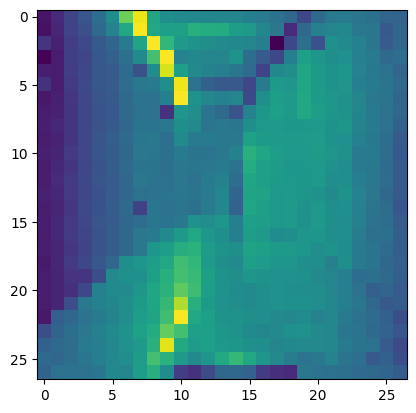

In [251]:
TRAIN_ID = 10
plt.imshow(X_train[TRAIN_ID].reshape(27,27))

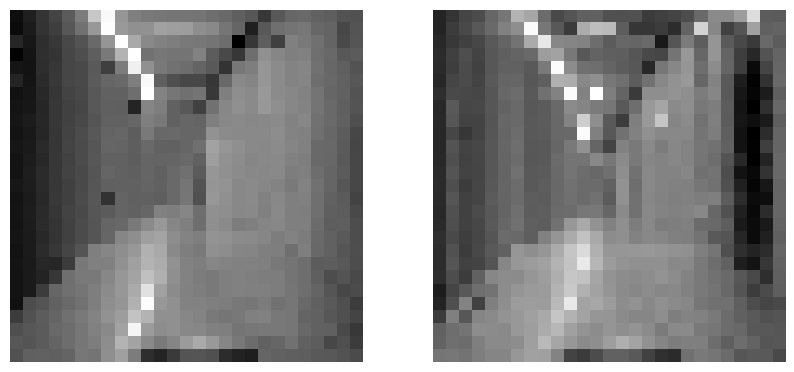

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(X_train[TRAIN_ID].reshape(27,27), cmap='gray')
axes[0].axis('off')
# axes[0].set_title('Original Image')
magic_sae.eval()
a = magic_sae(torch.Tensor(X_train[TRAIN_ID]).reshape(1,-1))
# Display the second image
axes[1].imshow(a.detach().numpy().reshape(27,27), cmap='gray')
axes[1].axis('off')
# axes[1].set_title('Rescaled Image')

plt.show()

(0.0, 0.2)

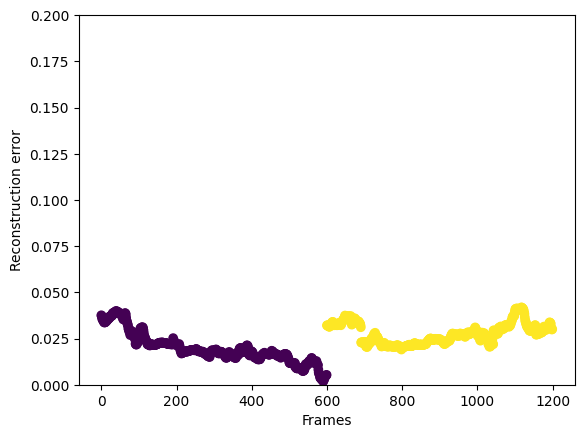

In [265]:
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=y_test)
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))

In [266]:
compute_reconstruction_error(magic_sae,X_train), compute_reconstruction_error(magic_sae,X_val) 

(0.030287224799394608, 0.029925163835287094)

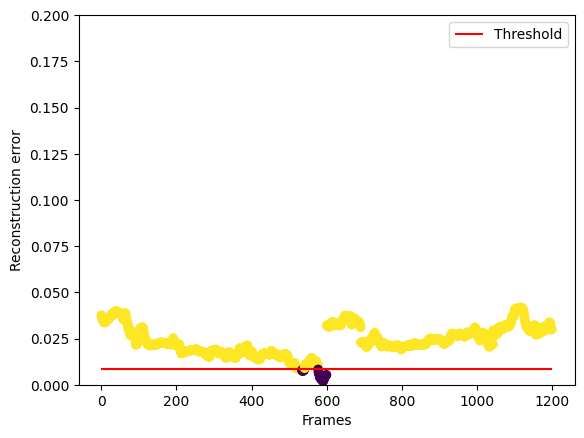

In [267]:
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=preds)
plt.hlines(y=THR,xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")

In [256]:
print("False Positives: ", len(FP))
print("False Negatives: ", len(FN))

False Positives:  38
False Negatives:  0


In [196]:
FP

[0,
 1,
 24,
 54,
 57,
 58,
 59,
 60,
 62,
 63,
 67,
 70,
 73,
 78,
 94,
 98,
 101,
 103,
 106,
 115,
 125,
 128,
 191,
 194,
 197,
 209,
 211,
 289,
 304,
 321,
 326,
 331,
 363,
 369,
 378,
 385,
 393,
 397,
 410,
 421,
 438,
 453,
 479,
 495,
 510,
 523,
 537,
 551,
 562,
 578,
 587,
 599]

In [227]:
retrain_dataset = TensorDataset(torch.Tensor(X_test_lr[FP]),torch.Tensor(X_test_lr[FP]))
retrain_dataloader = DataLoader(retrain_dataset, batch_size=BATCH_SIZE, shuffle=True) 
magic_train(magic_sae,retrain_dataloader,retrain_dataloader,EPOCHS_PER_FRAME,loss_fn,optimizer)

100%|██████████| 2/2 [00:00<00:00, 17.45it/s]


Train loss at epoch: 1: 0.05024220608174801


100%|██████████| 2/2 [00:00<00:00, 19.94it/s]


Train loss at epoch: 2: 0.0446585938334465


100%|██████████| 2/2 [00:00<00:00, 19.76it/s]


Train loss at epoch: 3: 0.035463061183691025


100%|██████████| 2/2 [00:00<00:00, 20.02it/s]


Train loss at epoch: 4: 0.02854094747453928


100%|██████████| 2/2 [00:00<00:00, 17.46it/s]


Train loss at epoch: 5: 0.025171469897031784


100%|██████████| 2/2 [00:00<00:00, 20.01it/s]


Train loss at epoch: 6: 0.026169827207922935


100%|██████████| 2/2 [00:00<00:00, 14.90it/s]


Train loss at epoch: 7: 0.02653689496219158


100%|██████████| 2/2 [00:00<00:00, 20.43it/s]


Train loss at epoch: 8: 0.026824401691555977


100%|██████████| 2/2 [00:00<00:00, 17.16it/s]


Train loss at epoch: 9: 0.02580931130796671


100%|██████████| 2/2 [00:00<00:00, 20.08it/s]

Train loss at epoch: 10: 0.02478098589926958


[0.05024220608174801,
 0.0446585938334465,
 0.035463061183691025,
 0.02854094747453928,
 0.025171469897031784,
 0.026169827207922935,
 0.02653689496219158,
 0.026824401691555977,
 0.02580931130796671,
 0.02478098589926958]

In [258]:
new_errors = compute_reconstructions(magic_sae,torch.Tensor(X_test_lr[FP]))

In [259]:
new_errors

tensor([0.0376, 0.0371, 0.0396, 0.0381, 0.0367, 0.0355, 0.0358, 0.0388, 0.0348,
        0.0327, 0.0299, 0.0293, 0.0228, 0.0257, 0.0306, 0.0263, 0.0218, 0.0215,
        0.0228, 0.0252, 0.0224, 0.0194, 0.0180, 0.0182, 0.0168, 0.0190, 0.0194,
        0.0158, 0.0143, 0.0184, 0.0161, 0.0110, 0.0089, 0.0095, 0.0140, 0.0128,
        0.0038, 0.0017], grad_fn=<MeanBackward1>)

In [260]:
new_errors < THR

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True])

In [261]:
new_frame_errors = np.zeros(len(frame_errors))

In [262]:
new_frame_errors[FP] = new_errors.detach().numpy()

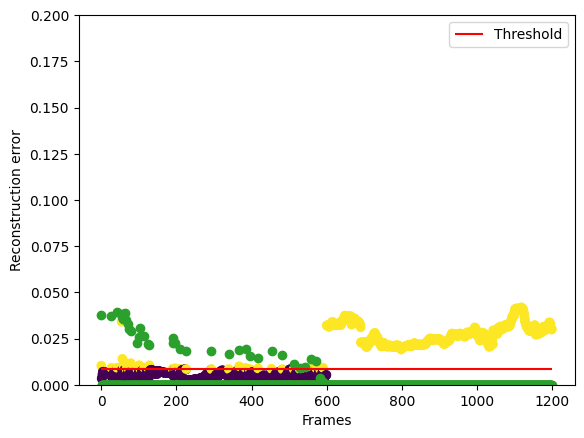

In [263]:
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=preds)
plt.scatter(np.arange(len(new_frame_errors)),new_frame_errors,c="tab:green")
plt.hlines(y=THR,xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")

In [273]:
pre_train = compute_reconstructions(magic_sae,X_train)

In [276]:
result = pre_train > THR
true_count = torch.sum(result).item()
false_count = result.numel() - true_count

true_count, false_count

(2003, 0)